#### 匯入模型與初始化

In [10]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
# 設定中文字型為微軟正黑體 (Microsoft JhengHei)
rcParams['font.family'] = 'Microsoft JhengHei'


import mmcv
from mmseg.apis import inference_model, init_model, show_result_pyplot
import numpy as np
import torch

# 讀取模型設定與權重
config_file = '../mmSeg_trained_models/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py'
checkpoint_file = '../mmSeg_trained_models/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

#### 全局變數

In [11]:
MODEL = init_model(config_file, checkpoint_file, device='cuda:0')

# 類別名稱
CLASSES = MODEL.dataset_meta['classes']
print(CLASSES)

# 顏色對應 (可選)
PALETTE = MODEL.dataset_meta.get('palette', None)
print(PALETTE)

# 定義人造物與自然物
HUMAN_MADE = {'road','sidewalk','building','wall','fence','pole',
            'traffic light','traffic sign','car','truck','bus','train',
            'motorcycle','bicycle'}
NATURE = {'vegetation','terrain','sky','person','rider'}

Loads checkpoint by local backend from path: ../mmSeg_trained_models/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
('road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle')
[[128, 64, 128], [244, 35, 232], [70, 70, 70], [102, 102, 156], [190, 153, 153], [153, 153, 153], [250, 170, 30], [220, 220, 0], [107, 142, 35], [152, 251, 152], [70, 130, 180], [220, 20, 60], [255, 0, 0], [0, 0, 142], [0, 0, 70], [0, 60, 100], [0, 80, 100], [0, 0, 230], [119, 11, 32]]


#### 定義視覺化功能

In [12]:
def compare_images(*images, titles=None):
    """
    比較多張影像，並可自訂標題。
    
    Args:
        *images: 任意數量的影像，BGR 格式 (mmcv.imread 讀取)
        titles: 可選，list of str，對應每張影像的標題
                如果未提供，預設依序為 ['原圖', '語意分割', '後處理', ...]
    """
    n = len(images)
    if titles is None:
        # 預設標題，依照影像數量生成
        default_titles = ['原圖', '語意分割', '後處理']
        titles = default_titles[:n] + [f'圖像{i+1}' for i in range(n - len(default_titles))]
    
    plt.figure(figsize=(5*n, 5))
    
    for i, img in enumerate(images):
        plt.subplot(1, n, i+1)
        # 如果是 BGR，轉 RGB
        if isinstance(img, np.ndarray) and img.shape[-1] == 3:
            plt.imshow(mmcv.bgr2rgb(img))
        else:
            plt.imshow(img)
        plt.title(titles[i])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

#### 定義單張圖片處理邏輯

In [13]:
import torch
import numpy as np
import mmcv
from mmseg.apis import inference_model

def process_batch_frames(sample_list, titles=None, show_comapre=False):
    """
    直接對 SampleList 使用 inference_model，並做人造/自然分類與可視化。
    
    Args:
        sample_list (SampleList or list of samples): MMseg 的 SampleList 或多張 sample
        titles (list, optional): 顯示標題列表，預設 ['原圖', '語意分割', '後處理']
        show_comapre (bool): 是否顯示對比圖
    
    Returns:
        imgs_rgb_list (list of np.ndarray): 原圖 RGB
        seg_classified_list (list of np.ndarray): 人造/自然分類結果
        ratios_list (list of tuple): 每個 sample 的 (human_ratio, nature_ratio)
    """
    if titles is None:
        titles = ['原圖', '語意分割', '後處理']

    # 直接 batch 推論
    results = inference_model(MODEL, sample_list)
    if not isinstance(results, list):
        results = [results]

    imgs_rgb_list = []
    seg_classified_list = []
    ratios_list = []

    # 定義語意分割顏色與人造/自然顏色
    seg_colors = np.array([
        [128, 64, 128], [244, 35, 232], [70, 70, 70], [102, 102, 156],
        [190, 153, 153], [153, 153, 153], [250, 170, 30], [220, 220, 0],
        [107, 142, 35], [152, 251, 152], [70, 130, 180], [220, 20, 60],
        [255, 0, 0], [0, 0, 142], [0, 0, 70], [0, 60, 100],
        [0, 80, 100], [0, 0, 230], [119, 11, 32]
    ], dtype=np.uint8)
    
    processed_colors = np.zeros_like(seg_colors)
    for j, cls in enumerate(CLASSES):
        if cls in HUMAN_MADE:
            processed_colors[j] = [255, 0, 0]
        else:
            processed_colors[j] = [0, 255, 0]

    for result in results:
        # 取得原圖
        if hasattr(result, 'metainfo') and 'img' in result.metainfo:
            img = result.metainfo['img']
        else:
            # fallback：若 Sample 沒有存原圖，則用 pred_sem_seg shape 製作空圖
            seg_shape = result.pred_sem_seg.shape
            img = np.zeros((seg_shape[-2], seg_shape[-1], 3), dtype=np.uint8)
        
        img_rgb = mmcv.bgr2rgb(img) if img.shape[2] == 3 else img
        imgs_rgb_list.append(img_rgb)

        # 取得分割索引
        seg_map = result.pred_sem_seg
        if hasattr(seg_map, 'data'):
            seg_map = seg_map.data
        if isinstance(seg_map, torch.Tensor):
            seg_map = seg_map.squeeze().cpu().numpy()
        if seg_map.ndim == 3:
            seg_map = seg_map.argmax(axis=0)
        seg_map = seg_map.astype(np.int64)

        # 重新分類
        seg_classified = np.zeros_like(seg_map, dtype=np.int64)
        for j, cls in enumerate(CLASSES):
            mask = (seg_map == j)
            seg_classified[mask] = 1 if cls in HUMAN_MADE else 2
        seg_classified_list.append(seg_classified)

        # 計算比例
        label_type = np.array([0 if cls in HUMAN_MADE else 1 for cls in CLASSES])
        human_pixels = np.sum(label_type[seg_map] == 0)
        nature_pixels = np.sum(label_type[seg_map] == 1)
        total_pixels = seg_map.size
        human_ratio = human_pixels / total_pixels
        nature_ratio = nature_pixels / total_pixels
        ratios_list.append((human_ratio, nature_ratio))

        # 可視化
        if show_comapre:
            seg_rgb = seg_colors[seg_map]
            seg_processed_rgb = processed_colors[seg_map]
            compare_images(img_rgb, seg_rgb, seg_processed_rgb, titles=titles)
            print(f"Human ratio: {human_ratio:.3f}, Nature ratio: {nature_ratio:.3f}")

    return imgs_rgb_list, seg_classified_list, ratios_list


In [14]:
def process_single_frame(frame, titles=None,show_comapre=False):
    """
    對單張影像（frame）進行語意分割、重新分類，並顯示原圖 / 分割結果 / 後處理結果。
    
    Args:
        frame (np.ndarray): 已讀取的影像 BGR 或 RGB 陣列
        titles (list, optional): 顯示標題列表，預設 ['原圖', '語意分割', '後處理']
    
    Returns:
        img_rgb (np.ndarray): 原圖 RGB
        seg_classified (np.ndarray): 重新分類結果
    """

    if titles is None:
        titles = ['原圖', '語意分割', '後處理']

    # 將 frame 從 BGR 轉成 RGB（如果需要）
    img_rgb = mmcv.bgr2rgb(frame) if frame.shape[2] == 3 else frame

    # 推論
    result = inference_model(MODEL, img_rgb)

    # 取得分割索引
    if hasattr(result, 'pred_sem_seg'):
        seg_map = result.pred_sem_seg
        if hasattr(seg_map, 'data'):
            seg_map = seg_map.data
        if isinstance(seg_map, torch.Tensor):
            seg_map = seg_map.squeeze().cpu().numpy()
        if seg_map.ndim == 3:
            seg_map = seg_map.argmax(axis=0)
        seg_map = seg_map.astype(np.int64)
    else:
        raise ValueError("SegDataSample 沒有 pred_sem_seg 屬性")

    # 重新分類：人造物 -> 1，自然物 -> 2
    seg_classified = np.zeros_like(seg_map, dtype=np.int64)
    for i, cls in enumerate(CLASSES):
        mask = (seg_map == i)
        if cls in HUMAN_MADE:
            seg_classified[mask] = 1
        else:
            seg_classified[mask] = 2

    # 定義顏色映射：語意分割彩圖、後處理彩圖
    seg_colors = np.array([
        [128, 64, 128],   # road
        [244, 35, 232],   # sidewalk
        [70, 70, 70],     # building
        [102, 102, 156],  # wall
        [190, 153, 153],  # fence
        [153, 153, 153],  # pole
        [250, 170, 30],   # traffic light
        [220, 220, 0],    # traffic sign
        [107, 142, 35],   # vegetation
        [152, 251, 152],  # terrain
        [70, 130, 180],   # sky
        [220, 20, 60],    # person
        [255, 0, 0],      # rider
        [0, 0, 142],      # car
        [0, 0, 70],       # truck
        [0, 60, 100],     # bus
        [0, 80, 100],     # train
        [0, 0, 230],      # motorcycle
        [119, 11, 32]     # bicycle
    ], dtype=np.uint8)

    # 後處理彩圖：人造物紅色，自然物綠色
    processed_colors = np.zeros_like(seg_colors)
    for i, cls in enumerate(CLASSES):
        if cls in HUMAN_MADE:
            processed_colors[i] = [255, 0, 0]
        else:
            processed_colors[i] = [0, 255, 0]

    # 將索引轉成彩圖
    seg_rgb = seg_colors[seg_map]
    seg_processed_rgb = processed_colors[seg_map]

    # 顯示結果
    if show_comapre:
        compare_images(img_rgb, seg_rgb, seg_processed_rgb, titles=titles)

    # 計算人造/自然比例
    label_type = np.array([0 if cls in HUMAN_MADE else 1 for cls in CLASSES])
    human_pixels = np.sum(label_type[seg_map] == 0)
    nature_pixels = np.sum(label_type[seg_map] == 1)
    total_pixels = seg_map.size
    human_ratio = human_pixels / total_pixels
    nature_ratio = nature_pixels / total_pixels
    if show_comapre:
        print(f"人造物比例: {human_ratio:.3f}")
        print(f"自然物比例: {nature_ratio:.3f}")

    return img_rgb, seg_classified, (human_ratio,nature_ratio)


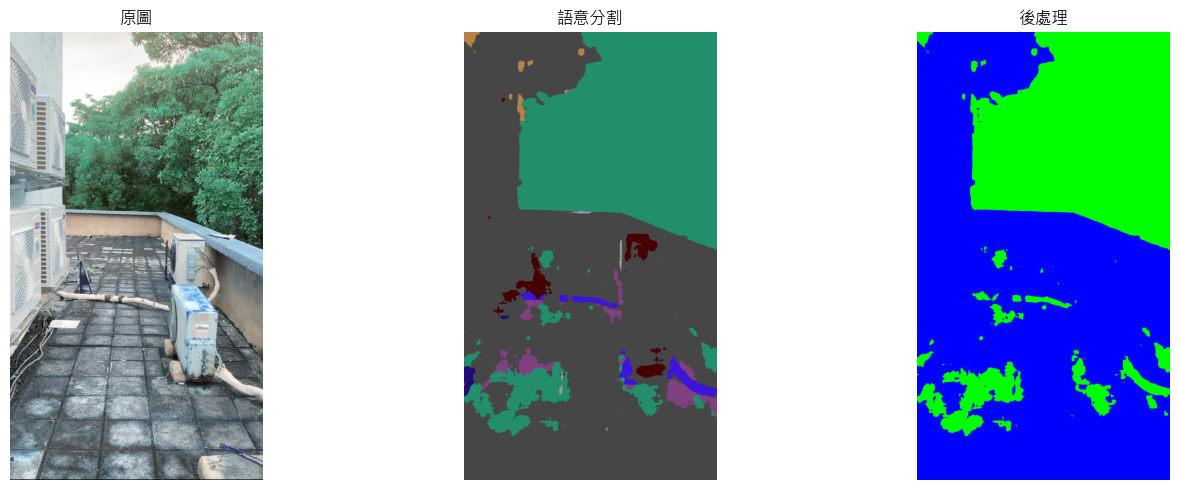

人造物比例: 0.647
自然物比例: 0.353


In [15]:

# 測試影像
img = mmcv.imread('../dataset\S__61571147.jpg')
result = process_single_frame(img, show_comapre=True)

#### 測試影片

In [ ]:
# from mmcv import VideoReader
# import mmcv

# # 讀影片
# video = VideoReader('../dataset/0.0-30.0.mp4')

# frames = [frame for frame in video]  # list of ndarray
# print(f"Total frames: {len(frames)}")
# frames = frames[:10]
# print(f"Total frames: {len(frames)}")
# # 對 batch 推論
# results = inference_model(MODEL, frames)  # 直接傳入 list of images

# # results 會是一個 list of SegDataSample
# for i, result in enumerate(results):
#     seg_map = result.pred_sem_seg.data.squeeze().cpu().numpy()
#     if seg_map.ndim == 3:
#         seg_map = seg_map.argmax(axis=0)
#     print(f"Frame {i} seg_map shape: {seg_map.shape}")


Total frames: 901
Total frames: 10


KeyboardInterrupt: 

In [13]:
# 處理影片
human_ratio_list = []
nature_ratio_list = []
video = mmcv.VideoReader('../dataset/0.0-30.0.mp4')

result = process_batch_frames(video)

# for i, frame in enumerate(video):
#     if i % 1 == 0:  # 每100幀處理一次
#         print(f"第{i}/{len(video)}偵畫面 處理中...", end='\r')
#         img_rgb, seg_classified, (human_ratio, nature_ratio) = process_single_frame(frame, show_comapre=False)
#         human_ratio_list.append(human_ratio)
#         nature_ratio_list.append(nature_ratio)

# 繪製比例隨時間變化
# plt.figure(figsize=(12,5))
# plt.plot(human_ratio_list, label='人造物比例', color='red')
# plt.plot(nature_ratio_list, label='自然物比例', color='green')
# plt.xlabel('偵數 (每100幀)')
# plt.ylabel('比例')
# plt.title('影片中人造物與自然物比例變化')
# plt.legend()
# plt.grid(True)
# plt.show()

KeyError: 'img'